# Personalização da arquitetura da rede neural

In [1]:
# Python ≥3.5 é necessário
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 é necessário
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 é necessário
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

# Para mostrar figuras
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Personalização de funções de perda

Vamos começar carregando e preparando o conjunto de dados de habitação da Califórnia. Primeiro o carregamos, depois o dividimos em um conjunto de treinamento, um conjunto de validação e um conjunto de teste e, finalmente, dimensionamos o conjunto de dados:

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [3]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

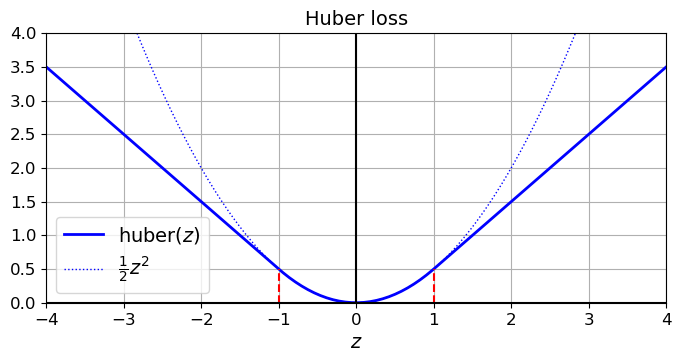

In [4]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [5]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [6]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [7]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.6441 - mae: 1.0062 - val_loss: 0.2412 - val_mae: 0.5336
Epoch 2/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2146 - mae: 0.5083 - val_loss: 0.2208 - val_mae: 0.5086


## Salvando e carregando modelos com objetos personalizados

In [8]:
model.save("my_model_with_a_custom_loss.h5")

In [9]:
model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn})

In [10]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [11]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [12]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2342 - mae: 0.4990 - val_loss: 0.2623 - val_mae: 0.4968
Epoch 2/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2254 - mae: 0.4903 - val_loss: 0.2450 - val_mae: 0.4933


In [13]:
model.save("my_model_with_a_custom_loss_threshold_2.h5")

In [14]:
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})

In [15]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.2185 - mae: 0.4836 - val_loss: 0.2216 - val_mae: 0.4711
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2146 - mae: 0.4783 - val_loss: 0.2115 - val_mae: 0.4711


## Personalização de outros componentes

In [16]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [17]:
def my_softplus(z): 
    return tf.math.log(tf.exp(z) + 1.0)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): 
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [18]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [19]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights),
])

In [20]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [21]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 2.0293 - mae: 0.9842 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.7325 - mae: 0.5540 - val_loss: inf - val_mae: inf


In [22]:
model.save("my_model_with_many_custom_parts.h5")

In [23]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_softplus": my_softplus,
    })

## Métricas personalizadas

In [24]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [25]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [26]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [27]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 2.5934 - huber_fn: 0.9320
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.8377 - huber_fn: 0.2665


In [28]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[create_huber(2.0)])

In [29]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.1202 - huber_fn: 0.2435
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.1150 - huber_fn: 0.2336


In [30]:
history.history["loss"][0], history.history["huber_fn"][0] * sample_weight.mean()

(0.12017738074064255, 0.12081847868983926)

## Camadas personalizadas

In [31]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) 

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

In [32]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [33]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

In [34]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 1.3382 - val_loss: 0.6640
Epoch 2/2
162/162 [==============================] - 0s 1ms/step - loss: 0.5029


0.5029376149177551

In [35]:
model.save("my_model_with_a_custom_layer.h5")

In [36]:
model = keras.models.load_model("my_model_with_a_custom_layer.h5",
                                custom_objects={"MyDense": MyDense})